<a href="https://colab.research.google.com/github/aworklab/everydayPython/blob/main/ex_20221026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 오늘의 목표
* Customer Analysis 
* Iterator

In [1]:
import pandas as pd 
import numpy as np 
import plotnine as gg
from plotnine import ggplot, aes 
import matplotlib.pyplot as plt 
import seaborn as sns
from datetime import datetime, date,time, timezone, timedelta
import os
import re

from functools import reduce
from collections import defaultdict

# Customer Analysis

In [2]:
os.listdir()

['.config',
 'online_retail.xlsx',
 'match_result_test.csv',
 'mall_customers.csv',
 'sales_vs_discount.csv',
 'sample-sales-data.csv',
 'sales.csv',
 '1_customers_dataset.csv',
 '1_order_payments_dataset.csv',
 'sales_data_with_stores.csv',
 'scanner_data.csv',
 'groceries.csv',
 'mock_sales_data.csv',
 'online_retail_II.xlsx',
 'test.csv',
 'ecommerce-data.csv',
 'KPMG_VI_New_raw_data_update_final.csv',
 '1_orders_dataset.csv',
 'KPMG_VI_New_raw_data_update_final.xlsx',
 'sample_data']

In [4]:
df = pd.read_csv('ecommerce-data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [5]:
df.columns = ['_'.join(re.split('(?=[A-Z][a-z])', a[0].lower() + a[1:])).lower() for a in df.columns]
df.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [10]:
df = df[(~df.invoice_no.astype(str).str.contains('C')) & (df.country == 'United Kingdom')]
df.invoice_date = pd.to_datetime(df.invoice_date, infer_datetime_format= True)
df['date'] = df.invoice_date.to_numpy().astype('datetime64[D]')
df['week'] = df['date'] - df['date'].dt.weekday.astype('timedelta64[D]')
df['month'] = df.invoice_date.to_numpy().astype('datetime64[M]')
df['rev'] = df.quantity * df.unit_price
df = df.groupby(['customerid', 'date', 'week'])['rev'].sum().reset_index()
df.head()

,customerid,date,week,rev
0,12346.0,2011-01-18,2011-01-17,77183.60
1,12747.0,2010-12-05,2010-11-29,358.56
2,12747.0,2010-12-13,2010-12-13,347.71
3,12747.0,2011-01-20,2011-01-17,303.04
4,12747.0,2011-03-01,2011-02-28,310.78


In [12]:
df2 = df.groupby(['customerid','week'])['rev'].sum().reset_index().sort_values(['customerid','week'])
df2.head()

,customerid,week,rev
0,12346.0,2011-01-17,77183.60
1,12747.0,2010-11-29,358.56
2,12747.0,2010-12-13,347.71
3,12747.0,2011-01-17,303.04
4,12747.0,2011-02-28,310.78


In [13]:
list_npu = df2.groupby(['customerid']).head(1)
list_week = df2['week'].sort_values().unique()

In [21]:
res = list()

for weeks in list_week :

  temp_npu = list_npu[list_npu['week'] == weeks]
  temp_pu = df2[df2['customerid'].isin(temp_npu['customerid'])]

  temp_pu['npu_week'] = np.repeat(weeks, len(temp_pu))
  temp_pu['diff'] = (temp_pu['week'] - temp_pu['npu_week']).dt.days // 7
  temp = temp_pu.groupby(['npu_week', 'diff'])['customerid'].count().reset_index().rename(columns = {'customerid':'pu'})
  temp['ratio'] = round(temp['pu']/temp['pu'].max() * 100, 2)
  temp['npu_week'] = temp['npu_week'].astype(str)

  res.append(temp)

res = pd.concat(res).reset_index().drop('index', axis = 1)
res = pd.melt(res, id_vars = ['npu_week', 'diff'], var_name = 'type')
res.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,npu_week,diff,type,value
0,2010-11-29,0,pu,278.0
1,2010-11-29,1,pu,58.0
2,2010-11-29,2,pu,67.0
3,2010-11-29,3,pu,19.0
4,2010-11-29,5,pu,56.0


/usr/local/lib/python3.7/dist-packages/plotnine/facets/facet.py:393: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.


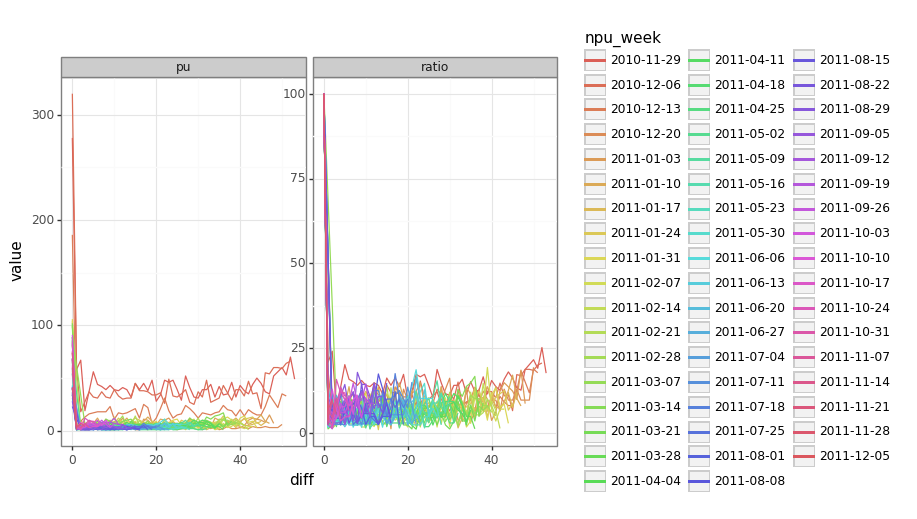

<ggplot: (8756951004949)>

In [22]:
(
    ggplot(res, aes('diff', 'value', color = 'npu_week')) +
    gg.geom_line() +
    gg.facet_wrap('~type', scales = 'free_y') +
    gg.theme_bw()
)

# Iterator

In [33]:
names = np.random.choice(['park', 'kim', 'yoo'], 1000, replace = True)

def get_scores(names) :

  unique, count = np.unique(names, return_counts=True)
  uniques = dict(zip(unique, count))

  res = list()

  for k, v in uniques.items() : 

    m = np.random.normal(50, 30, 1)
    s = np.random.randint(3, 20, 1)
    score = [abs(a) if a <= 100 else 100 for a in np.random.normal(abs(m), s, v)]
    temp = pd.DataFrame({'name' : np.repeat(k, v), 'score' : score})
    res.append(temp)
  
  res = pd.concat(res).reset_index().drop('index', axis = 1)
  
  return res

res = get_scores(names)
res.head()

,name,score
0,kim,9.966191
1,kim,11.648185
2,kim,3.355597
3,kim,16.288944
4,kim,7.063762


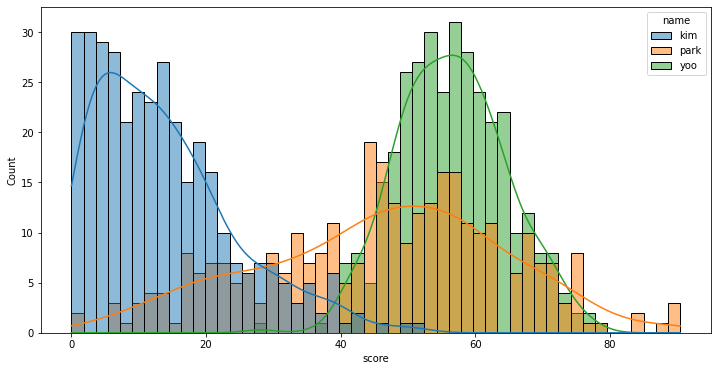

In [34]:
plt.figure(figsize = [12, 6])
sns.histplot(data = res, x = 'score', hue = 'name', kde = True, bins = 50)

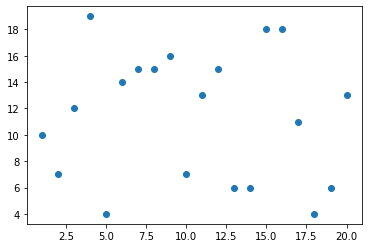

In [39]:
plt.plot(range(1,21), np.random.randint(3, 20, 20), 'o')

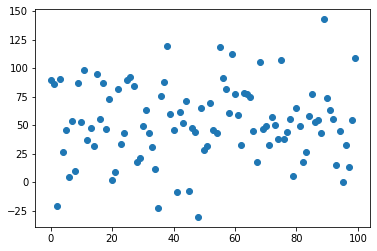

In [40]:
plt.plot(range(100), np.random.normal(50, 30, 100), 'o')

(array([73., 72., 62., 57., 54., 62., 40., 69., 56., 57., 57., 65., 56.,
        46., 56., 53., 65.]),
 array([ 3.        ,  3.94117647,  4.88235294,  5.82352941,  6.76470588,
         7.70588235,  8.64705882,  9.58823529, 10.52941176, 11.47058824,
        12.41176471, 13.35294118, 14.29411765, 15.23529412, 16.17647059,
        17.11764706, 18.05882353, 19.        ]),
 <a list of 17 Patch objects>)

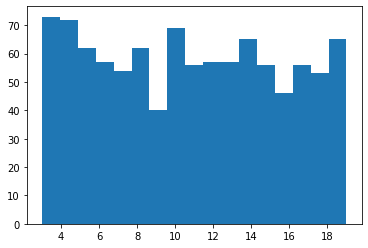

In [50]:
plt.hist(np.random.randint(3, 20, 1000), bins = 20-3)

(array([ 1.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  3.,  3.,  5.,  7.,  8.,
        12., 13., 16., 21., 24., 23., 26., 26., 40., 45., 41., 43., 50.,
        49., 37., 41., 43., 56., 40., 51., 42., 43., 33., 23., 24., 23.,
        13., 15.,  9.,  8.,  8.,  6.,  6.,  7.,  4.,  4.,  4.]),
 array([-54.9291536 , -51.17369089, -47.41822817, -43.66276546,
        -39.90730274, -36.15184002, -32.39637731, -28.64091459,
        -24.88545188, -21.12998916, -17.37452644, -13.61906373,
         -9.86360101,  -6.1081383 ,  -2.35267558,   1.40278713,
          5.15824985,   8.91371257,  12.66917528,  16.424638  ,
         20.18010071,  23.93556343,  27.69102614,  31.44648886,
         35.20195158,  38.95741429,  42.71287701,  46.46833972,
         50.22380244,  53.97926516,  57.73472787,  61.49019059,
         65.2456533 ,  69.00111602,  72.75657873,  76.51204145,
         80.26750417,  84.02296688,  87.7784296 ,  91.53389231,
         95.28935503,  99.04481774, 102.80028046, 106.55574318,
        110.

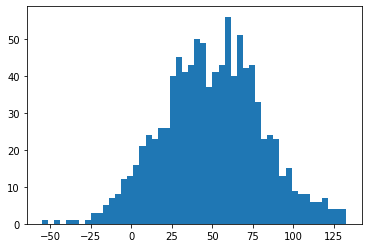

In [53]:
plt.hist(np.random.normal(50, 30, 1000), bins = 50)